In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping


In [14]:
df1 = pd.read_csv("1.csv")

ukraine_data = df1[df1['key_apple_mobility'] == 'Ukraine']
data = ukraine_data[['date', 'confirmed']]


C:\Users\afedy\AppData\Local\Temp\ipykernel_18920\505390812.py:1: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("1.csv")


In [15]:
import datetime 

def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

data['date'] = data['date'].apply(str_to_datetime)

C:\Users\afedy\AppData\Local\Temp\ipykernel_18920\364274201.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = data['date'].apply(str_to_datetime)


In [16]:
data.index = data.pop('date')
data['confirmed'] = data['confirmed'].fillna(method='bfill')
data[data.index >= '2020-03-03']
data = data[~data['confirmed'].duplicated(keep='first')]
data

C:\Users\afedy\AppData\Local\Temp\ipykernel_18920\1904295743.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['confirmed'] = data['confirmed'].fillna(method='bfill')
C:\Users\afedy\AppData\Local\Temp\ipykernel_18920\1904295743.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['confirmed'] = data['confirmed'].fillna(method='bfill')


,confirmed
date,
2020-01-03,1.0
2020-03-13,3.0
2020-03-16,7.0
2020-03-17,14.0
2020-03-19,16.0
...,...
2023-03-05,5701743.0
2023-03-06,5701855.0
2023-03-07,5701959.0


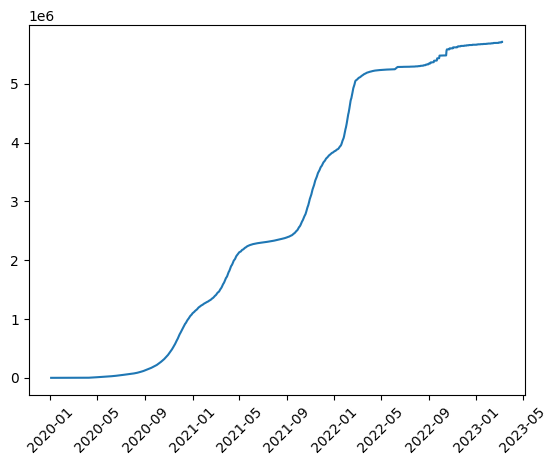

In [17]:
plt.plot(data.index, data['confirmed'])
plt.xticks(rotation=45)
plt.show()

In [18]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    target_date = first_date
    
    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)
        
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['confirmed'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
        
        if last_time:
            break
        
        target_date = next_date

        if target_date == last_date:
            last_time = True
        
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
    
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]
    
    ret_df['Target'] = Y

    return ret_df


windowed_df = df_to_windowed_df(data, 
                                '2020-04-15', 
                                '2023-03-01', 
                                n=15)
windowed_df

,Target Date,Target-15,Target-14,Target-13,Target-12,Target-11,Target-10,Target-9,Target-8,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2020-04-15,645.0,794.0,897.0,1072.0,1225.0,1308.0,1319.0,1462.0,1668.0,1892.0,2203.0,2511.0,2777.0,3102.0,3372.0,3764.0
1,2020-04-16,794.0,897.0,1072.0,1225.0,1308.0,1319.0,1462.0,1668.0,1892.0,2203.0,2511.0,2777.0,3102.0,3372.0,3764.0,4161.0
2,2020-04-17,897.0,1072.0,1225.0,1308.0,1319.0,1462.0,1668.0,1892.0,2203.0,2511.0,2777.0,3102.0,3372.0,3764.0,4161.0,4662.0
3,2020-04-18,1072.0,1225.0,1308.0,1319.0,1462.0,1668.0,1892.0,2203.0,2511.0,2777.0,3102.0,3372.0,3764.0,4161.0,4662.0,5106.0
4,2020-04-19,1225.0,1308.0,1319.0,1462.0,1668.0,1892.0,2203.0,2511.0,2777.0,3102.0,3372.0,3764.0,4161.0,4662.0,5106.0,5449.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,2023-02-25,5686735.0,5686871.0,5686987.0,5687053.0,5687118.0,5692468.0,5692544.0,5692665.0,5692846.0,5693003.0,5693110.0,5693215.0,5693260.0,5693342.0,5693474.0,5693596.0
1011,2023-02-26,5686871.0,5686987.0,5687053.0,5687118.0,5692468.0,5692544.0,5692665.0,5692846.0,5693003.0,5693110.0,5693215.0,5693260.0,5693342.0,5693474.0,5693596.0,5693650.0
1012,2023-02-27,5686987.0,5687053.0,5687118.0,5692468.0,5692544.0,5692665.0,5692846.0,5693003.0,5693110.0,5693215.0,5693260.0,5693342.0,5693474.0,5693596.0,5693650.0,5693753.0
1013,2023-02-28,5687053.0,5687118.0,5692468.0,5692544.0,5692665.0,5692846.0,5693003.0,5693110.0,5693215.0,5693260.0,5693342.0,5693474.0,5693596.0,5693650.0,5693753.0,5693846.0


In [19]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((1015,), (1015, 15, 1), (1015,))

(102, 15, 1)


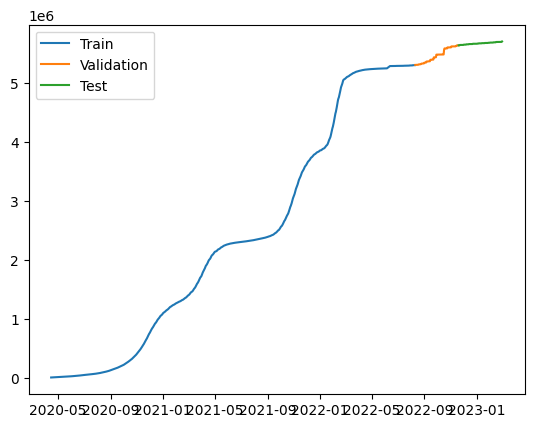

In [20]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])
print(X_test.shape)

In [21]:
scaler = MinMaxScaler()

X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_train_scaled = X_train_scaled.reshape(X_train.shape) 


X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
X_val_scaled = scaler.transform(X_val_reshaped)
X_val_scaled = X_val_scaled.reshape(X_val.shape)

X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
X_test_scaled = scaler.transform(X_test_reshaped)
X_test_scaled = X_test_scaled.reshape(X_test.shape)
print(X_train_scaled.shape)

(812, 15, 1)


In [22]:
y_train_reshaped = y_train.reshape(-1, 1)
y_val_reshaped = y_val.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_val_scaled = scaler_y.transform(y_val_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)

In [23]:
window_size = 1
num_features = 15
output_size = 1
learning_rate = 0.000001
epochs = 1000

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape = (15,)),
    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.00000001)),
    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.00000001)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=0.4),
              loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=90, restore_best_weights=True)
model.fit(X_train_scaled, y_train_scaled, epochs=epochs, validation_data=(X_val_scaled, y_val_scaled), callbacks=[early_stopping])



c:\Users\afedy\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2213 - val_loss: 0.7919
Epoch 2/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2290 - val_loss: 0.7835
Epoch 3/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2022 - val_loss: 0.7752
Epoch 4/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2094 - val_loss: 0.7671
Epoch 5/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2193 - val_loss: 0.7591
Epoch 6/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2117 - val_loss: 0.7511
Epoch 7/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1978 - val_loss: 0.7432
Epoch 8/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2044 - val_loss: 0.7353
Epoch 9/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2079 - val_loss: 0.7275
Epoch 10/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1912 - val_loss: 0.7197
Epoch 11/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1915 - val_loss: 0.7121
Epoch 12/1000
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

In [25]:
train_predictions = model.predict(X_train_scaled)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_train_scaled, train_predictions)
mse = mean_squared_error(y_train_scaled, train_predictions)

print("Mean Absolute Error:", scaler_y.inverse_transform(np.array(mae).reshape(-1, 1))[0][0])
print("Mean Squared Error:", scaler_y.inverse_transform(np.array(mse).reshape(-1, 1))[0][0])


Mean Absolute Error: 13737.347
Mean Squared Error: 3807.2336


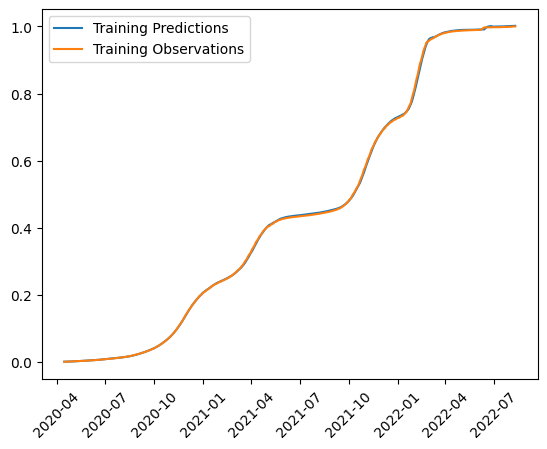

In [27]:


plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train_scaled)
plt.legend(['Training Predictions', 'Training Observations'])
plt.xticks(rotation=45)
plt.show()

In [28]:
train_predictions_unscaled = scaler_y.inverse_transform(np.array(train_predictions).reshape(-1, 1))
y_train_original = scaler_y.inverse_transform(np.array(y_train_scaled).reshape(-1, 1))

from sklearn.metrics import r2_score
r_squared = r2_score(y_train_original, train_predictions_unscaled)

print("R-squared:", r_squared)

R-squared: 0.9999301440078169


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


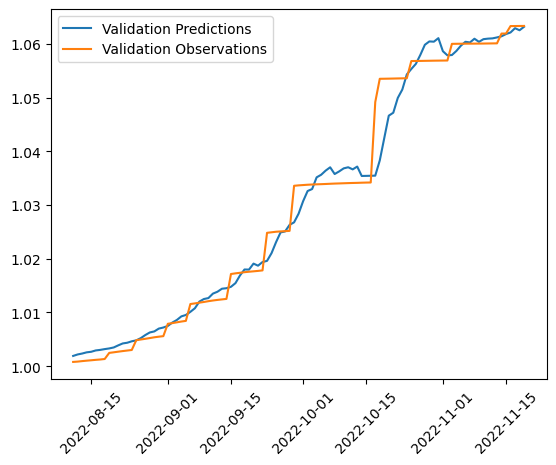

In [29]:
val_predictions = model.predict(X_val_scaled)

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val_scaled)
plt.legend(['Validation Predictions', 'Validation Observations'])
plt.xticks(rotation=45)
plt.show()

In [30]:
mae = mean_absolute_error(y_val_scaled, val_predictions)
mse = mean_squared_error(y_val_scaled, val_predictions)

print("Mean Absolute Error:", scaler_y.inverse_transform(np.array(mae).reshape(-1, 1))[0][0])
print("Mean Squared Error:", scaler_y.inverse_transform(np.array(mse).reshape(-1, 1))[0][0])
y_val_scaled.shape

Mean Absolute Error: 14177.175
Mean Squared Error: 3815.8513


(101, 1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


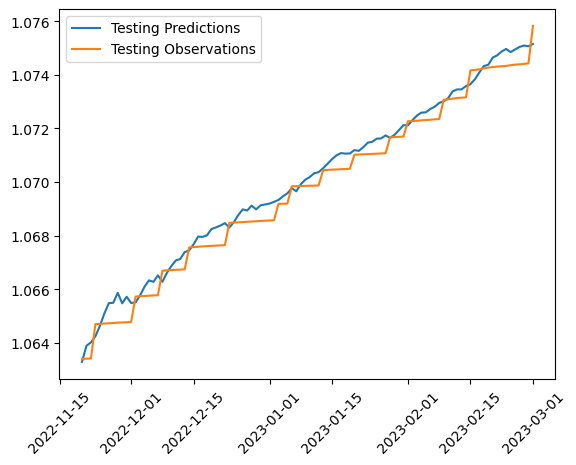

In [33]:
X_test_prediction = model.predict(X_test_scaled)
plt.plot(dates_test, X_test_prediction)
plt.plot(dates_test, y_test_scaled)
plt.legend(['Testing Predictions', 'Testing Observations'])
plt.xticks(rotation=45)
plt.show()

In [32]:
future_predictions = []
for _ in range(10):
    next_day_prediction = model.predict(X_test_prediction[-15:].reshape(1, 15, 1))
    future_predictions.append(next_day_prediction)

    next_day_prediction = next_day_prediction.reshape(1, -1)
    X_test_prediction_last_4 = X_test_prediction[-14:].reshape(-1, 1)  

    X_test_prediction = np.concatenate((X_test_prediction_last_4, next_day_prediction), axis=0)

future_amount = scaler_y.inverse_transform(np.array(future_predictions).reshape(-1, 1))
future_amount

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


array([[5699828.5],
       [5700224.5],
       [5700851.5],
       [5701359. ],
       [5701723.5],
       [5702102.5],
       [5702563.5],
       [5703261. ],
       [5703701. ],
       [5704429.5]], dtype=float32)